In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

import sys
sys.path.append('../')
from src import datasets, metrics

In [2]:
trainfile = Path('../data/heart_train.parq').resolve()
testfile = Path('../data/heart_test.parq').resolve()
# trainfile = Path('../data/heart_big_train.parq').resolve()
# testfile = Path('../data/heart_big_test.parq').resolve()
trainfile, testfile

(PosixPath('/home/azureuser/code/mads-exam-24/data/heart_train.parq'),
 PosixPath('/home/azureuser/code/mads-exam-24/data/heart_test.parq'))

Get the 1D data into a 2D matrix

In [3]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

traindataset.to(device)
testdataset.to(device)


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(1))

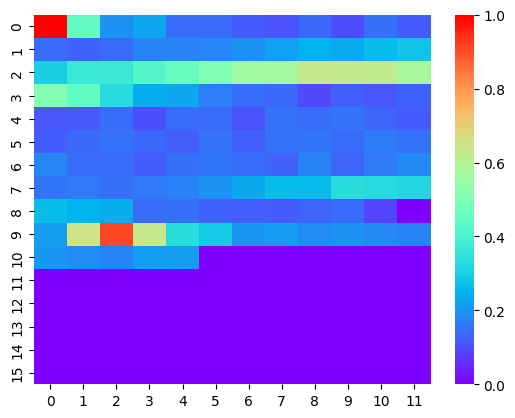

In [4]:
x, y = traindataset[0]
# Assuming your tensor is named 'tensor'
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [5]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(363, 90)

In [6]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

The ConvBlock makes it easier to stack block in the model.
Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, etc.
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        dropout = config['dropout']
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.conv(x)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



In [9]:
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        dropout = config['dropout']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

#        for i in range(config['num_layers']):
#            self.convolutions.extend([ConvBlock(hidden, hidden), nn.ReLU()])

        for i in range(config['num_layers']):
            self.convolutions.extend([ResidualBlock(hidden, hidden), nn.ReLU()])
        
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8*6) * hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),  # Add dropout here
            nn.Linear(hidden, config['num_classes']),
 #           nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
#            print(f'After {conv.__class__.__name__}, shape: {x.shape}')
        x = self.dense(x)
        return x

In [16]:
import numpy as np
from sklearn.metrics import recall_score

class ThresholdedRecall:
    def __init__(self, threshold: float = 0.2, average: str = 'micro'):
        self.threshold = threshold
        self.average = average

    def __repr__(self) -> str:
        return f"ThresholdedRecall_threshold_{self.threshold}_average_{self.average}"

    def __call__(self, y, yhat):
        yhat_thresholded = (yhat >= self.threshold).astype(int)
        
        if y.ndim == 1:
            # Binary classification case
            y_true = y
            y_pred = yhat_thresholded[:, 0]  # Assuming binary classification has shape (n_samples, 1)
        else:
            # Multilabel case
            y_true = y
            y_pred = yhat_thresholded
        
        return recall_score(
            y_true, y_pred, average=self.average, zero_division=np.nan
        )


In [17]:
# from src import models
config = {
    'hidden' :111,
    'num_layers' : 3,
    'num_classes' : 2, # 5 for big dataset
    'shape' : shape,
    'dropout': 0.27,
}
#model = models.CNN(config)
model = CNN(config)
model.to(device)
model(x).shape

torch.Size([32, 2])

In [18]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [19]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [20]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("2D conv model")

<Experiment: artifact_location='/home/azureuser/code/mads-exam-24/notebooks/mlruns/1', creation_time=1718732376163, experiment_id='1', last_update_time=1718732376163, lifecycle_stage='active', name='2D conv model', tags={}>

In [21]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau

    settings = TrainerSettings(
        epochs=10,
        metrics=[accuracy, f1micro, f1macro, precision, recall, ThresholdedRecall(threshold=0.2, average='micro')],
        #metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="heart2D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 5},
        earlystop_kwargs=None
    )

 #   trainer = Trainer(
        # model=model,
        # settings=settings,
        # loss_fn=loss_fn,
        # optimizer=torch.optim.Adam,
        # traindataloader=trainstreamer.stream(),
        # validdataloader=teststreamer.stream(),
        # scheduler=None,
       # )
    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=scheduler,
        )
    trainer.loop()


2024-07-04 19:21:59.464 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to heart2D/20240704-192159
100%|██████████| 363/363 [01:13<00:00,  4.92it/s]
2024-07-04 19:23:19.739 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4673 test 0.2852 metric ['0.8729', '0.8729', '0.8114', '0.8729', '0.7890', '0.2760']
 10%|█         | 1/10 [02:15<20:20, 135.56s/it]


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# # Generate the classification report
# report = classification_report(y, yhat, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])

# print(report)

f1 = f1_score(y, yhat, average = "macro")
ps = precision_score(y, yhat, average = "macro")
rs = recall_score(y, yhat, average = "macro")
ac = accuracy_score(y, yhat)

print(f"f1_score: {f1}")
print(f"precision_score: {ps}")
print(f"recall_score: {rs}")
print(f"accuracy_score: {ac}")

f1_score: 0.9460962008930835
precision_score: 0.947857284432831
recall_score: 0.9443772519589901
accuracy_score: 0.9569444444444445


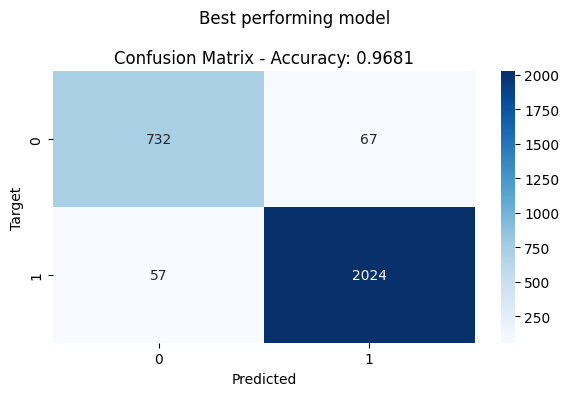

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
ac = accuracy_score(y, yhat)
# cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

#plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
#plot.set(xlabel="Predicted", ylabel="Target")

# Plotting
plt.figure(figsize=(6, 4))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Accuracy: {ac:.4f}")
plt.suptitle("Best performing model - Dataset 1")
plt.xlabel("Predicted")
plt.ylabel("Target")
plt.tight_layout()
plt.savefig("confusion_matrix_small_best_model.png")
plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Generate the classification report
report = classification_report(y, yhat, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])

print(report)

# f1 = f1_score(y, yhat, average = "macro")
# ps = precision_score(y, yhat, average = "macro")
# rs = recall_score(y, yhat, average = "macro")
ac = accuracy_score(y, yhat)

# print(f"f1_score: {f1}")
# print(f"precision_score: {ps}")
# print(f"recall_score: {rs}")
# print(f"accuracy_score: {ac}")